# Homework 5 (appendix)
### Author: Mateusz Sieniawski

In [1]:
import shap
import random
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb

from pdpbox import pdp, get_dataset, info_plots
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
from collections.abc import Iterable

np.random.seed(42)
random.seed(42)

In [94]:
df = pd.read_csv("kc_house_data.csv")
df = df.drop(["id", "date", "bedrooms"], axis=1)
df = df.dropna()

target_col = "price"
X = df.drop([target_col], axis=1)
Y = df[[target_col]]

In [95]:
# split data into train and test sets
seed = 42
test_size = 0.2
train_size = 0.8
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, train_size=train_size, random_state=seed)

## XGBoost

In [76]:
model = xgb.XGBRegressor(eval_metric="rmsle")
model.fit(X_train, y_train)
print(model)

y_pred = model.predict(X_test)
xgboost_loss = msle(y_test, y_pred)
print(f"Loss: {xgboost_loss:.3f}")

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmsle',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Loss: 0.030


In [79]:
xgboost_variable_importance = {}

for col in range(len(X_train.columns)):
    X_shuffled = X_train.copy()
    X_shuffled = X_shuffled.reset_index(drop=True)
    X_shuffled.iloc[:, col] = X_shuffled.iloc [:, col] .sample (frac = 1) .reset_index (drop = True)
    X_shuffled = X_shuffled.reset_index(drop=True)
    
    model = xgb.XGBRegressor(eval_metric="rmsle")
    model.fit(X_shuffled, y_train)

    y_pred = model.predict(X_test)
    loss = msle(y_test, y_pred)
    print(f"{X_train.columns[col]} shuffled | Loss: {loss:.3f} | Variable importance: {loss/xgboost_loss}")
    xgboost_variable_importance[X_train.columns[col]] = loss/xgboost_loss

bathrooms shuffled | Loss: 0.030 | Variable importance: 0.998939287839286
sqft_living shuffled | Loss: 0.032 | Variable importance: 1.0399870793269572
sqft_lot shuffled | Loss: 0.032 | Variable importance: 1.0375186415750488
floors shuffled | Loss: 0.031 | Variable importance: 1.0133992319180056
waterfront shuffled | Loss: 0.032 | Variable importance: 1.0476326927130157
view shuffled | Loss: 0.031 | Variable importance: 1.021651691116814
condition shuffled | Loss: 0.032 | Variable importance: 1.0408420343434588
grade shuffled | Loss: 0.033 | Variable importance: 1.0839770380143168
sqft_above shuffled | Loss: 0.030 | Variable importance: 0.9768374094273666
sqft_basement shuffled | Loss: 0.030 | Variable importance: 0.9953831076672994
yr_built shuffled | Loss: 0.031 | Variable importance: 1.02577141317635
yr_renovated shuffled | Loss: 0.030 | Variable importance: 0.9961368684788271
zipcode shuffled | Loss: 0.032 | Variable importance: 1.0361163198117838
lat shuffled | Loss: 0.036 | Varia

In [81]:
with open('xgboost_2.pickle', 'wb') as handle:
    pickle.dump(xgboost_variable_importance, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Linear regression

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Regression loss: 0.977
bathrooms - 30560.37794244152
sqft_living - 94.02240973996723
sqft_lot - 0.16390039164594689
floors - 9455.866411535504
waterfront - 536489.6612749109
view - 56437.43850086548
condition - 25431.86371548751
grade - 100099.10923824478
sqft_above - 62.23240674515259
sqft_basement - 31.79000341004167
yr_built - -2542.9315504509855
yr_renovated - 20.56695459097645
zipcode - -570.6469059450417
lat - 609912.8013291623
long - -210053.20895639333
sqft_living15 - 25.258648894733017
sqft_lot15 - -0.3320255016798562


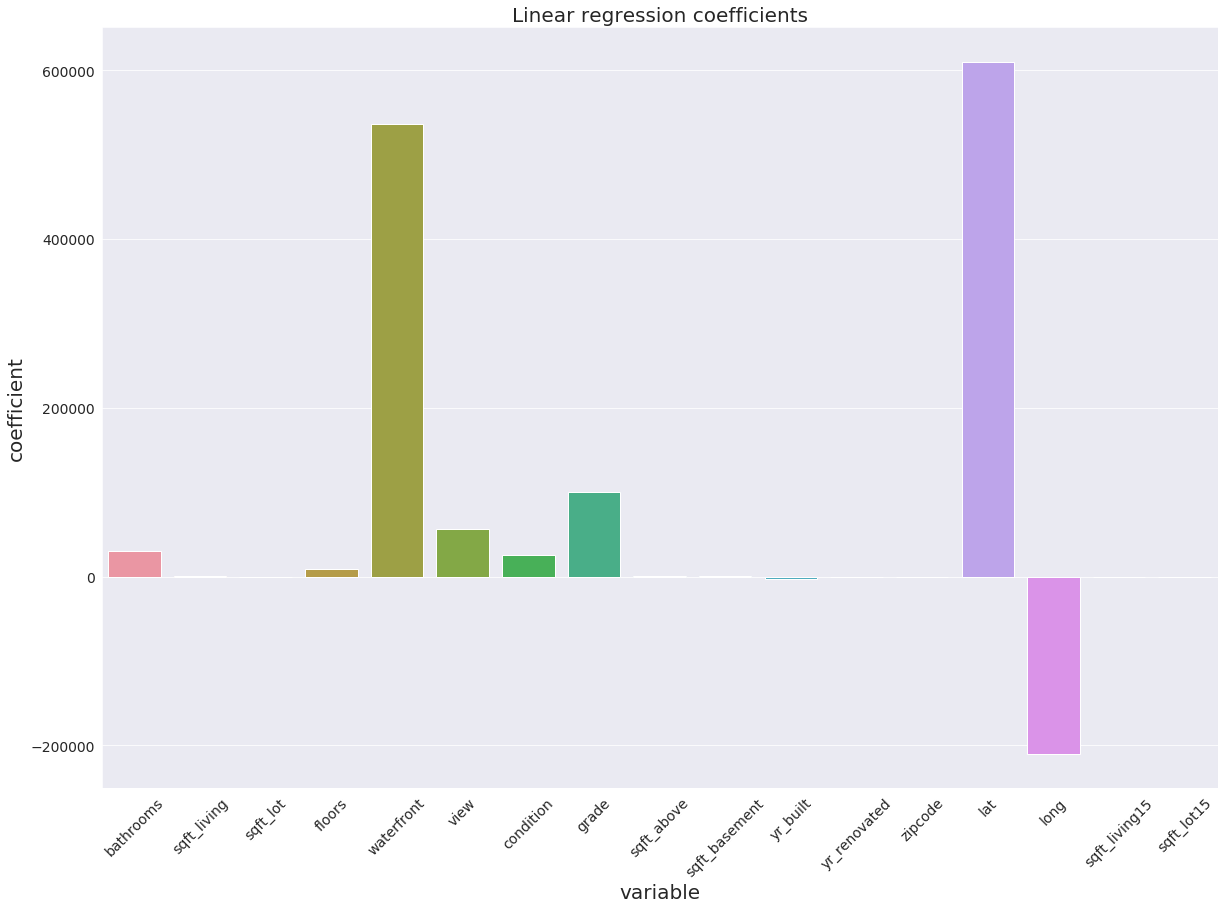

In [192]:
reg = LinearRegression().fit(X_train, y_train)
print(reg)

y_pred = reg.predict(X_test)
y_pred[y_pred <= 0] = 1e-6
reg_loss = msle(y_test, y_pred)
print(f"Regression loss: {reg_loss:.3f}")

for (coef, col) in zip(reg.coef_[0], X_train.columns):
    print(f"{col} - {coef}")

    

plt.figure(figsize = (20,14))
sns.barplot(X_train.columns, reg.coef_[0])
#g.set(ylim=(0.9, 1.25))

plt.title("Linear regression coefficients", fontsize=20)
plt.xlabel("variable", fontsize=20)
plt.ylabel("coefficient", fontsize=20)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

#plt.show()
plt.savefig("img/reg_coef.png")

In [100]:
reg_variable_importance = {}

for col in range(len(X_train.columns)):
    X_shuffled = X_train.copy()
    X_shuffled = X_shuffled.reset_index(drop=True)
    X_shuffled.iloc[:, col] = X_shuffled.iloc [:, col] .sample (frac = 1) .reset_index (drop = True)
    X_shuffled = X_shuffled.reset_index(drop=True)
    
    reg = LinearRegression().fit(X_shuffled, y_train)

    y_pred = reg.predict(X_test)
    y_pred[y_pred <= 0] = 1e-6
    loss = msle(y_test, y_pred)
    print(f"{X_train.columns[col]} shuffled | Loss: {loss:.3f} | Variable importance: {loss/reg_loss}")
    reg_variable_importance[X_train.columns[col]] = loss/reg_loss

bathrooms shuffled | Loss: 0.941 | Variable importance: 0.9633053458258325
sqft_living shuffled | Loss: 0.977 | Variable importance: 0.9995811768033727
sqft_lot shuffled | Loss: 0.980 | Variable importance: 1.0023578972757081
floors shuffled | Loss: 0.981 | Variable importance: 1.004133944385052
waterfront shuffled | Loss: 0.945 | Variable importance: 0.9670656957691958
view shuffled | Loss: 1.053 | Variable importance: 1.0777843862045164
condition shuffled | Loss: 1.081 | Variable importance: 1.1063140735729053
grade shuffled | Loss: 0.533 | Variable importance: 0.5455257292602479
sqft_above shuffled | Loss: 1.005 | Variable importance: 1.028688810401141
sqft_basement shuffled | Loss: 1.005 | Variable importance: 1.0280989759734307
yr_built shuffled | Loss: 1.223 | Variable importance: 1.2513514596280615
yr_renovated shuffled | Loss: 0.951 | Variable importance: 0.9725724833122125
zipcode shuffled | Loss: 0.963 | Variable importance: 0.985546032899762
lat shuffled | Loss: 0.590 | Vari

In [102]:
with open('reg_2.pickle', 'wb') as handle:
    pickle.dump(reg_variable_importance, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Random forest

In [103]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print(rf)

y_pred = rf.predict(X_test)
rf_loss = msle(y_test, y_pred)
print(f"Random forest loss: {rf_loss:.3f}")

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Regression loss: 0.032


In [104]:
rf_variable_importance = {}

for col in range(len(X_train.columns)):
    X_shuffled = X_train.copy()
    X_shuffled = X_shuffled.reset_index(drop=True)
    X_shuffled.iloc[:, col] = X_shuffled.iloc [:, col] .sample (frac = 1) .reset_index (drop = True)
    X_shuffled = X_shuffled.reset_index(drop=True)
    
    rf = RandomForestRegressor()
    rf.fit(X_shuffled, y_train)

    y_pred = rf.predict(X_test)
    loss = msle(y_test, y_pred)
    print(f"{X_train.columns[col]} shuffled | Loss: {loss:.3f} | Variable importance: {loss/rf_loss}")
    rf_variable_importance[X_train.columns[col]] = loss/rf_loss

bathrooms shuffled | Loss: 0.032 | Variable importance: 1.005926666397753
sqft_living shuffled | Loss: 0.032 | Variable importance: 1.0102101451390766
sqft_lot shuffled | Loss: 0.032 | Variable importance: 1.0032880257551735
floors shuffled | Loss: 0.031 | Variable importance: 0.9861757657807412
waterfront shuffled | Loss: 0.033 | Variable importance: 1.0303003677557698
view shuffled | Loss: 0.033 | Variable importance: 1.0297697122374667
condition shuffled | Loss: 0.032 | Variable importance: 1.0147340270023861
grade shuffled | Loss: 0.034 | Variable importance: 1.0760131722419737
sqft_above shuffled | Loss: 0.032 | Variable importance: 1.0010270577873575
sqft_basement shuffled | Loss: 0.032 | Variable importance: 0.9984542229226131
yr_built shuffled | Loss: 0.032 | Variable importance: 0.9954809051032524
yr_renovated shuffled | Loss: 0.032 | Variable importance: 0.9970154331186102
zipcode shuffled | Loss: 0.032 | Variable importance: 1.0086892445559388
lat shuffled | Loss: 0.044 | Va

In [105]:
with open('rf_2.pickle', 'wb') as handle:
    pickle.dump(rf_variable_importance, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Comparison

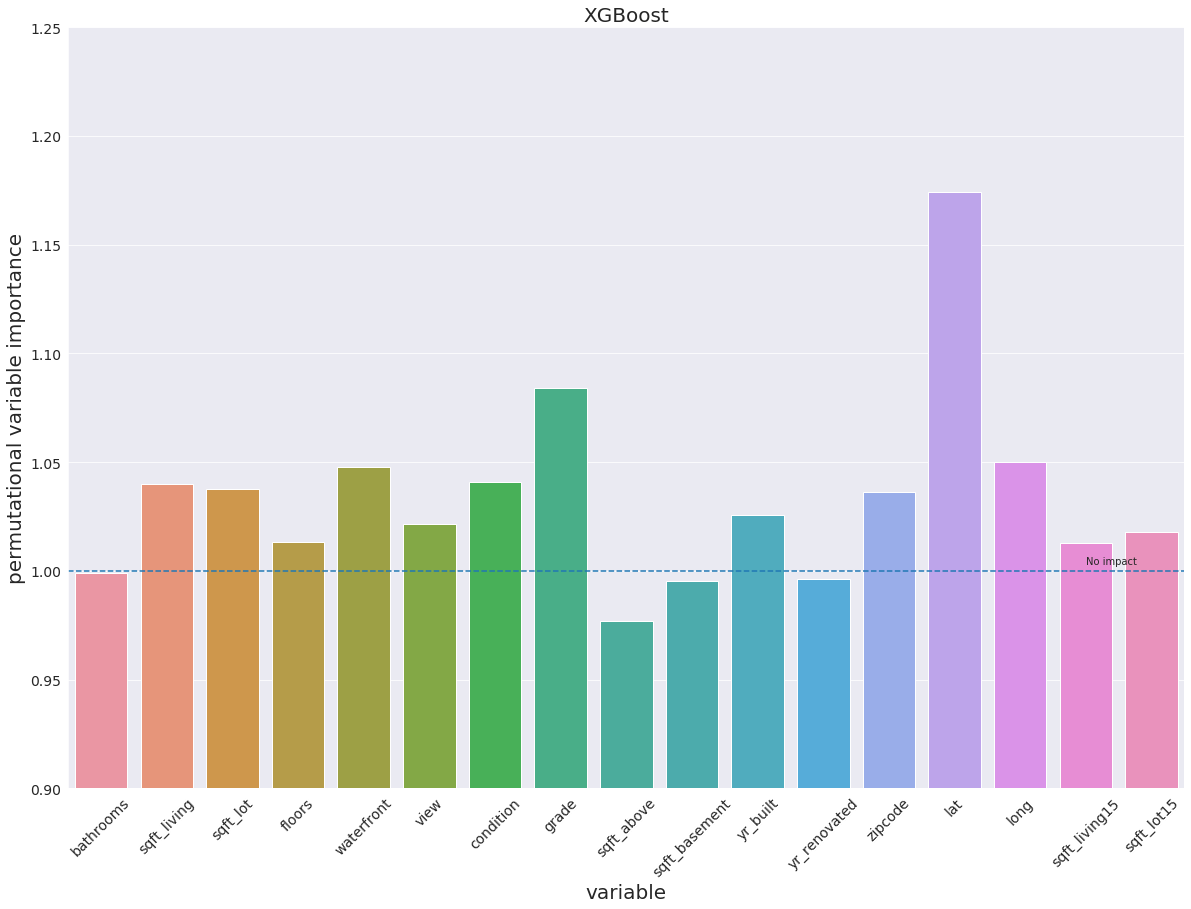

In [193]:
import seaborn as sns
sns.set_style("darkgrid")

plt.figure(figsize = (20,14))
g = sns.barplot(list(xgboost_variable_importance.keys()), list(xgboost_variable_importance.values()))
g.set(ylim=(0.9, 1.25))

plt.title("XGBoost", fontsize=20)
plt.xlabel("variable", fontsize=20)
plt.ylabel("permutational variable importance", fontsize=20)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

g.axhline(1, ls='--')
g.text(15,1.003, "No impact")

plt.savefig("img/xgboost.png")

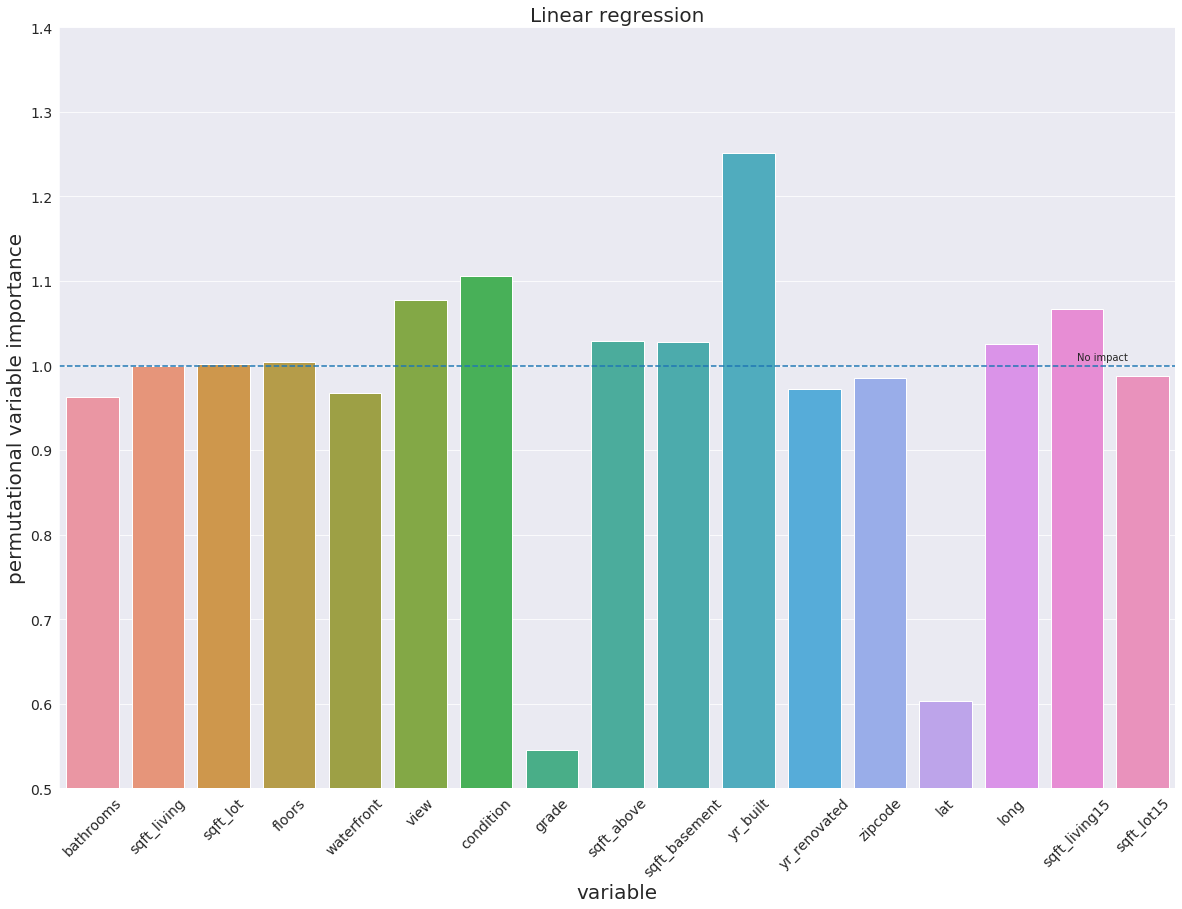

In [195]:
import seaborn as sns
sns.set_style("darkgrid")

plt.figure(figsize = (20,14))
g = sns.barplot(list(reg_variable_importance.keys()), list(reg_variable_importance.values()))
g.set(ylim=(0.5, 1.4))

plt.title("Linear regression", fontsize=20)
plt.xlabel("variable", fontsize=20)
plt.ylabel("permutational variable importance", fontsize=20)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

g.axhline(1, ls='--')
g.text(15,1.007, "No impact")

plt.savefig("img/reg.png")

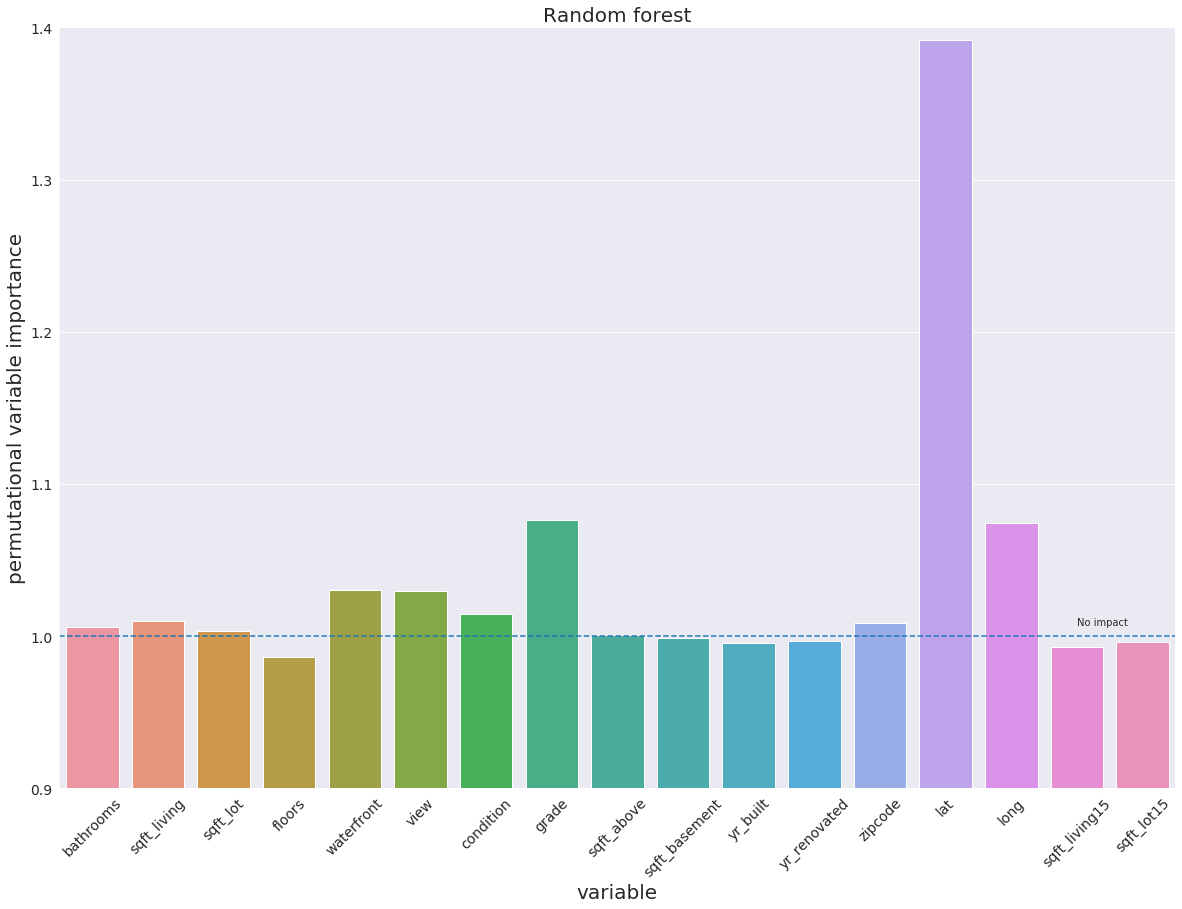

In [194]:
import seaborn as sns
sns.set_style("darkgrid")

plt.figure(figsize = (20,14))
g = sns.barplot(list(rf_variable_importance.keys()), list(rf_variable_importance.values()))
g.set(ylim=(0.9, 1.4))

plt.title("Random forest", fontsize=20)
plt.xlabel("variable", fontsize=20)
plt.ylabel("permutational variable importance", fontsize=20)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

g.axhline(1, ls='--')
g.text(15,1.007, "No impact")

plt.savefig("img/rf.png")